In [ ]:
import pandas as pd
import spacy
import nltk
import re
import unidecode
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import os

In [2]:
df = pd.read_parquet(r"D:\Python for Data Analysis\alerj\leis-ordinarias\todos\leis_ordinarias.parquet")

In [3]:
#criar uma coluna data_proposicao ao reconhecer na coluna tramitacao o texto "[Data: mm/dd/yyyy]"
df['data_proposicao'] = df['tramitacao'].str.extract(r'\[Data:\s*(\d{2}/\d{2}/\d{4})\]').squeeze()
df['data_proposicao'] = pd.to_datetime(df['data_proposicao'], format='%m/%d/%Y', errors='coerce')

#criar coluna legislação
#se 2011 <= ano <= 2014 em data_proposicao -> Legislação 2011-2015
#se 2015 <= ano <= 2018 em data_proposicao -> Legislação 2015-2019
#se 2019 <= ano <= 2022 em data_proposicao -> Legislação 2019-2023
def classify_legislation(date):
    if pd.isna(date):
        return 'Desconhecido'
    year = date.year
    if 2011 <= year <= 2014:
        return 'Legislação 2011-2015'
    elif 2015 <= year <= 2018:
        return 'Legislação 2015-2019'
    elif 2019 <= year <= 2022:
        return 'Legislação 2019-2023'
    else:
        return 'Fora do intervalo'
df['legislacao'] = df['data_proposicao'].apply(classify_legislation)
df[['data_proposicao', 'legislacao']].head(10)

,data_proposicao,legislacao
0,2011-02-04,Legislação 2011-2015
1,2011-02-04,Legislação 2011-2015
2,2011-02-04,Legislação 2011-2015
3,2011-02-04,Legislação 2011-2015
4,2011-02-04,Legislação 2011-2015
5,2011-02-04,Legislação 2011-2015
6,2011-02-04,Legislação 2011-2015
7,2011-02-04,Legislação 2011-2015
8,2011-02-04,Legislação 2011-2015
9,2011-02-04,Legislação 2011-2015


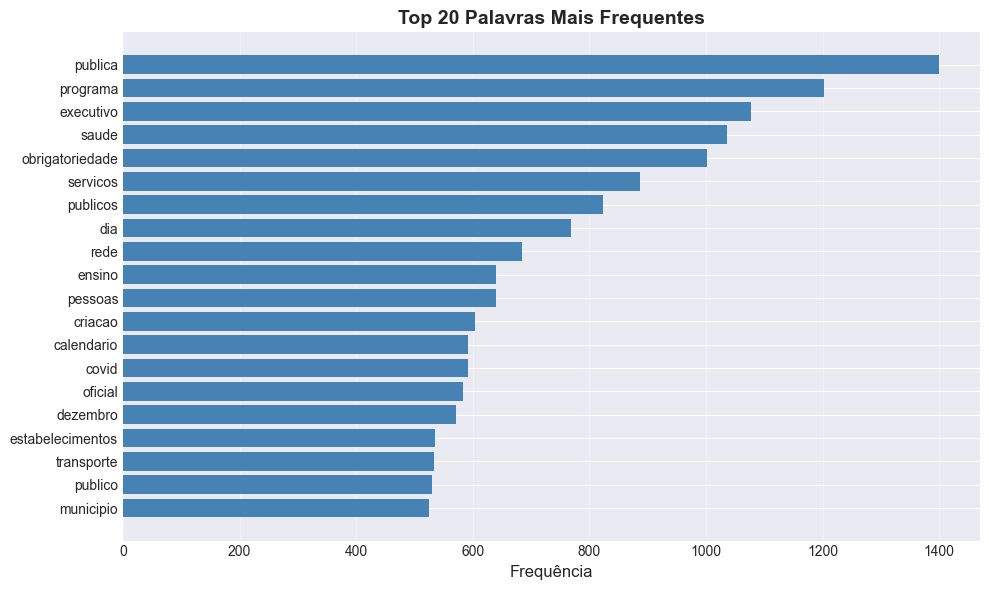

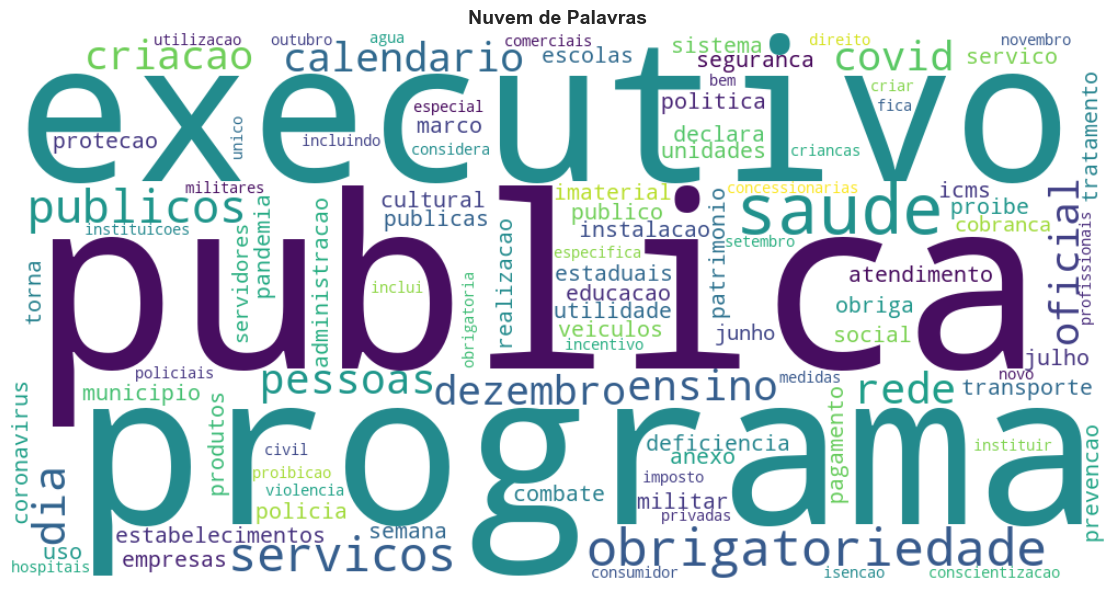

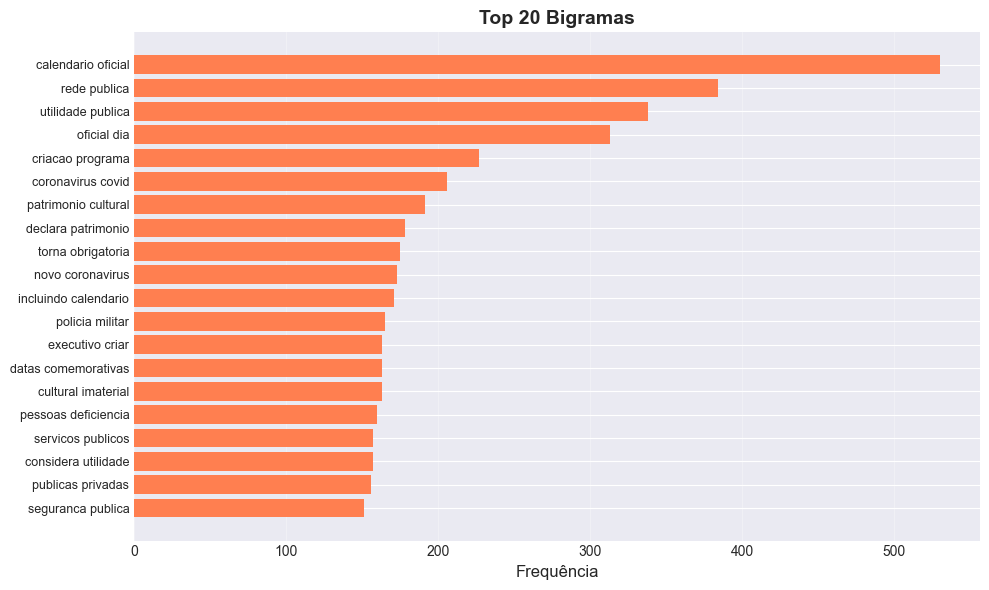

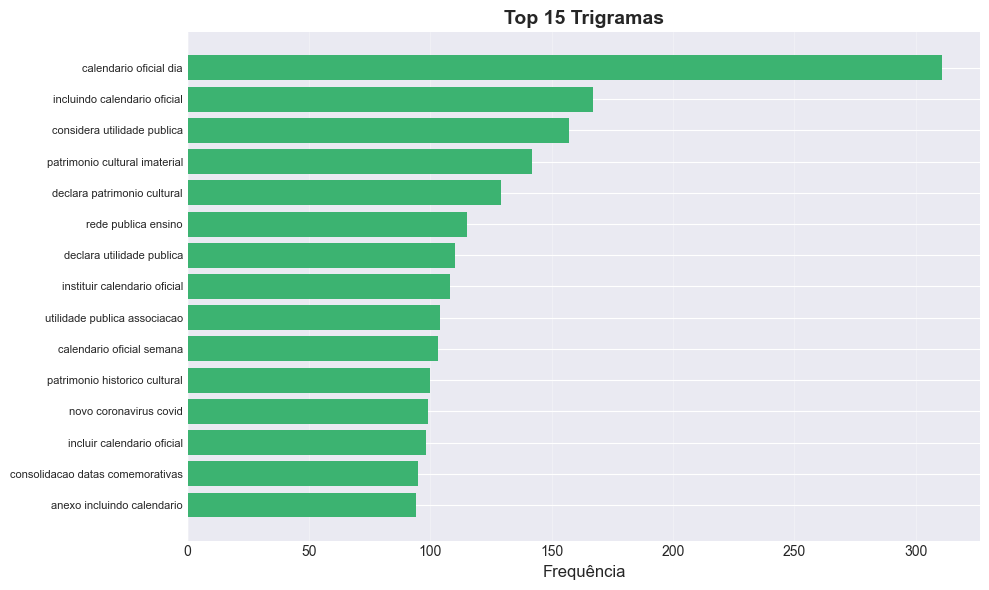

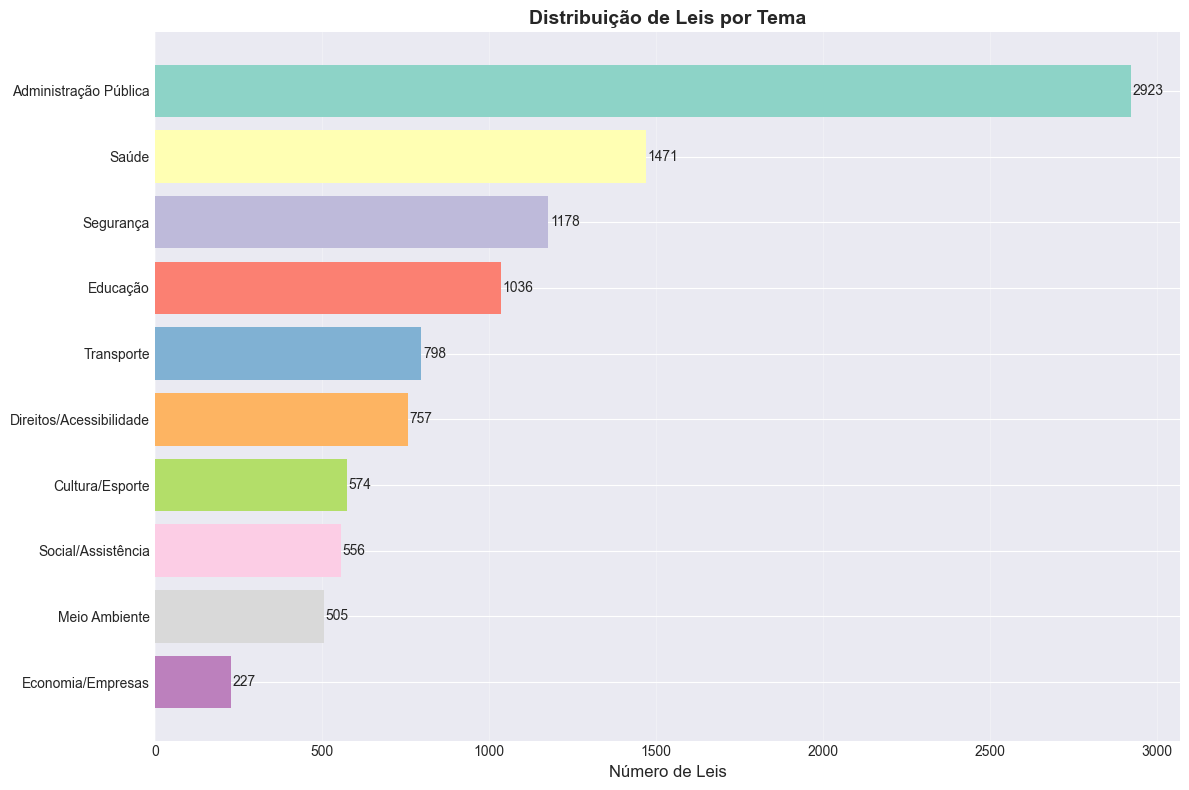

In [4]:
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# PRÉ-PROCESSAMENTO

STOPWORDS_PT = {
    'o', 'a', 'os', 'as', 'de', 'da', 'do', 'das', 'dos', 'em', 'no', 'na', 'nos', 'nas',
    'ao', 'aos', 'à', 'às', 'por', 'para', 'com', 'sem', 'sob', 'sobre', 'e', 'ou', 'que',
    'qual', 'quais', 'quando', 'onde', 'como', 'se', 'esse', 'essa', 'esses', 'essas',
    'este', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto',
    'isso', 'aquilo', 'um', 'uma', 'uns', 'umas', 'mais', 'menos', 'muito', 'muitos',
    'pouco', 'poucos', 'todo', 'toda', 'todos', 'todas', 'outro', 'outra', 'outros',
    'outras', 'mesmo', 'mesma', 'mesmos', 'mesmas', 'tal', 'tais', 'pelo', 'pela', 'pelos',
    'pelas', 'lhe', 'lhes', 'me', 'te', 'nos', 'vos', 'meu', 'minha', 'meus', 'minhas',
    'teu', 'tua', 'teus', 'tuas', 'seu', 'sua', 'seus', 'suas', 'nosso', 'nossa', 'nossos',
    'nossas', 'vosso', 'vossa', 'vossos', 'vossas', 'ser', 'estar', 'ter', 'haver', 'fazer',
    'ir', 'vir', 'ver', 'dar', 'poder', 'dever', 'ja', 'ainda', 'nao', 'nem', 'so', 'tambem',
    'ate', 'desde', 'entre', 'contra', 'apos', 'antes', 'depois', 'durante', 'mediante',
    'conforme', 'segundo', 'atraves', 'junto', 'dentro', 'fora', 'acima', 'abaixo',
    'lei', 'n', 'nº', 'nr', 'art', 'artigo', 'inciso', 'paragrafo', 'altera', 'dispoe',
    'estabelece', 'determina', 'autoriza', 'institui', 'cria', 'revoga', 'regulamenta',
    'janeiro', 'estado', 'rio', 'providencias', 'âmbito', 'estadual', 'forma', 'menciona', 'ambito'
}

def limpar_texto(texto):
    if pd.isna(texto):
        return ""
    texto = texto.lower()
    texto = re.sub(r'\b\d+\b', '', texto)
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def tokenizar_e_filtrar(texto, min_len=3):
    palavras = texto.split()
    return [p for p in palavras if p not in STOPWORDS_PT and len(p) >= min_len]

df['ementa_limpa'] = df['ementa'].apply(limpar_texto)
df['tokens'] = df['ementa_limpa'].apply(tokenizar_e_filtrar)

# FREQUÊNCIA DE PALAVRAS

todas_palavras = [palavra for tokens in df['tokens'] for palavra in tokens]
freq_palavras = Counter(todas_palavras)

#top 20 palavras
palavras_top20, freqs_top20 = zip(*freq_palavras.most_common(20))

#criar uma df das top 20 palavras
df_top20 = pd.DataFrame({'Palavra': palavras_top20, 'Frequência': freqs_top20})

plt.figure(figsize=(10, 6))
plt.barh(range(len(palavras_top20)), freqs_top20, color='steelblue')
plt.yticks(range(len(palavras_top20)), palavras_top20)
plt.gca().invert_yaxis()
plt.xlabel('Frequência', fontsize=12)
plt.title('Top 20 Palavras Mais Frequentes', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# NUVEM DE PALAVRAS

wordcloud = WordCloud(
    width=1000, height=500, background_color='white',
    colormap='viridis', max_words=100, relative_scaling=0.5
).generate_from_frequencies(freq_palavras)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# BIGRAMAS

bigramas = []
for tokens in df['tokens']:
    if len(tokens) >= 2:
        bigramas.extend([f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)])

freq_bigramas = Counter(bigramas)
top_20_bigramas = freq_bigramas.most_common(20)

bigramas_label, bigramas_freq = zip(*top_20_bigramas)

plt.figure(figsize=(10, 6))
plt.barh(range(len(bigramas_label)), bigramas_freq, color='coral')
plt.yticks(range(len(bigramas_label)), bigramas_label, fontsize=9)
plt.gca().invert_yaxis()
plt.xlabel('Frequência', fontsize=12)
plt.title('Top 20 Bigramas', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# TRIGRAMAS

trigramas = []
for tokens in df['tokens']:
    if len(tokens) >= 3:
        trigramas.extend([f"{tokens[i]} {tokens[i+1]} {tokens[i+2]}" for i in range(len(tokens)-2)])

freq_trigramas = Counter(trigramas)
top_15_trigramas = freq_trigramas.most_common(15)

trigramas_label, trigramas_freq = zip(*top_15_trigramas)

plt.figure(figsize=(10, 6))
plt.barh(range(len(trigramas_label)), trigramas_freq, color='mediumseagreen')
plt.yticks(range(len(trigramas_label)), trigramas_label, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel('Frequência', fontsize=12)
plt.title('Top 15 Trigramas', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# TEMAS PRINCIPAIS

temas = {
    'Educação': ['educacao', 'ensino', 'escola', 'professor', 'aluno', 'universidade', 'estudante'],
    'Saúde': ['saude', 'hospital', 'medico', 'paciente', 'atendimento', 'sus', 'sanitario'],
    'Meio Ambiente': ['ambiental', 'agua', 'residuos', 'lixo', 'reciclagem', 'poluicao', 'sustentavel', 'preservacao'],
    'Segurança': ['seguranca', 'policia', 'crime', 'violencia', 'protecao'],
    'Transporte': ['transporte', 'veiculo', 'onibus', 'transito', 'trem', 'metro'],
    'Economia/Empresas': ['empresa', 'comercio', 'comercial', 'economico', 'financeiro', 'mercado'],
    'Social/Assistência': ['social', 'assistencia', 'vulneravel', 'crianca', 'idoso', 'familia'],
    'Cultura/Esporte': ['cultura', 'cultural', 'esporte', 'esportivo', 'atleta', 'arte'],
    'Administração Pública': ['publico', 'publica', 'municipal', 'estadual', 'governo', 'servidor', 'executivo'],
    'Direitos/Acessibilidade': ['direito', 'acessibilidade', 'deficiencia', 'inclusao', 'igualitario']
}

contagem_temas = {}
for tema, palavras_chave in temas.items():
    count = sum(1 for tokens in df['tokens'] if any(palavra in tokens for palavra in palavras_chave))
    contagem_temas[tema] = count

temas_ordenados = sorted(contagem_temas.items(), key=lambda x: x[1], reverse=True)

# Visualização de temas
fig, ax = plt.subplots(figsize=(12, 8))
temas_labels, temas_counts = zip(*temas_ordenados)
bars = ax.barh(range(len(temas_labels)), temas_counts, color=plt.cm.Set3(range(len(temas_labels))))
ax.set_yticks(range(len(temas_labels)))
ax.set_yticklabels(temas_labels)
ax.invert_yaxis()
ax.set_xlabel('Número de Leis', fontsize=12)
ax.set_title('Distribuição de Leis por Tema', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, temas_counts)):
    ax.text(count + 5, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()